Indeed, in many situations you don't really need to know the implementation details. However, having a good understanding of how thins work can help you quickly home in on the appropriate model, the right training alogrithm to use, and a good set of hyperparameters for your task.

In this chapter, we will start by looking at the Linear Regression model, one of the simplest models there is. We will discuss 2 different ways to train it:
- Using a direct "closed-form" equation that directly computes the model parameters that best fit the model to the training set(i.e., the model parameters that minimize the cost function over the training set).
- Using an iterative optimization approach, called Gradient Descent(GD), that gradually tweaks the model parameters to minimize the cost function over the training set, eventually converging to the same set of parameters as the first method.

Next will look at the Polynomial Regression, a more complex model that can fit nonliear datasets. It has more parameters than Linear Regression and is more prone to overfitting the training data. Then we will look at several regularization techniques that can reduce the risk of overfitting the training set.

Finally, we will look at 2 more models that are commonly used for classification tasks:Logistic Regression and Softmax Regression.

# Linear Regression
Generally, a linear model makes a prediciton by simply computing a weighted sum of the input features, plus a constant called the *bias term or intercept term*.
$$\hat{y} = \theta_0+\theta_1x_1+\theta_2x_2+\dots++\theta_nx_n$$
- $\hat{y}$ is the predicted value.
- $n$ is the number of features.
- $x_i$ is the i^th feature value.
- $\theta_j$ is the j^th model parameter(including the bias term \theta_0 and the feature weights $\theta_0,\theta_1,\theta_2,\dots,\theta_n$

This can also be written much more concisely using a vectorized form.
$$\hat{y}=h_\theta(X)=\theta^T\cdot X$$
- $\theta$ is the model's *parameter vector*, containing the bias term $\theta_0$ and the feature weights $\theta_0$ to $\theta_n$
- $\theta^T$ is the transpose of $\theta$( a row vector instead of a column vector.
- $X$ is the instance's *feature vector*, containing $x_0$ to $x_n$, with $x_0$ is always to 1.
- $\theta^T\cdot$ $X$ is the dot product of $\theta^T$ and $X$
- $h_\theta$ is the hypothesis function, using the model parameters $\theta$.

So this is the LR model, now how do we train it? For this purpose, we first need a measure of how well(or poorly) the model fits the training data. A common performance measure of a regression model is the Root Mean Square Error(RMSE). Therefore, to train a LR model, you need to find the value of $\theta$ that minimizes the RMSE. In practice, it is simpler to minimize the MSE than the RMSE, and it leads to the same results(because the value that minimizes a function also minimizes its square root).

The MSE of a LR hypothesis $h_\theta$ on a training set $X$ is calculated using this equation.$$MSE(X,h_\theta)=\frac{1}{m}\sum_{i=1}^m(\theta^T\cdot X^{(i)} - y^{(i)})^2$$

NOTE: We write $h_\theta$ instead of $h$ in order to make it clear that the model is parametrized by the vector $\theta$. To simplify the notations, we will just write MSE($\theta$) instead of $MSE(X,h_\theta)$.

## The Normal Equation
To find the value of $\theta$ that minimizes the cost function, there is a *closed-form solution*. In other words, a mathematical equation that gives the result directly. This is called the **Normal Equation**.$$\hat{\theta}=(X^T\cdot X)^{-1}\cdot X^T\cdot y$$
- $\hat{\theta}$ is the value of $\theta$ that minimizes the cost function.
- $y$ is the vector of target values containing $y^{(1)}$ to $y^{(m)}$.

Let's generate some linear-looking data to test this equation:

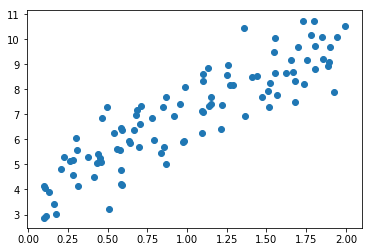

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

X = 2*np.random.rand(100,1)
y = 4+3*X + np.random.randn(100, 1)
plt.scatter(X,y)

Now compute $\hat{\theta}$ using the Normal Equation.

In [2]:
X_b = np.c_[np.ones((100,1)), X] # add x0=1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[3.87708817],
       [3.09517191]])

We would have hoped for $\theta_0=4$ and $\theta_1=3$ instead of $\theta_0=3.762$ and $\theta_1=3.129$. Closed enough, but the noise made it impossible to recover the exact parameters of the original function.

Now we could use $\hat{\theta}$ to make predicitons.

In [3]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new] # add x0=1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.87708817],
       [10.067432  ]])

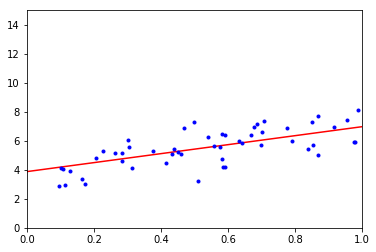

In [4]:
plt.plot(X_new, y_predict, 'r-')
plt.plot(X,y,'b.')
plt.axis([0,1,0,15])
plt.show()

The equivalent code using Scikit-Learn looks like this:

In [5]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
# 以下两个参数：截距，系数(1,2...n)
lin_reg.intercept_, lin_reg.coef_

(array([3.87708817]), array([[3.09517191]]))

In [6]:
lin_reg.predict(X_new)

array([[ 3.87708817],
       [10.067432  ]])

## Computational Complexity
The Normal Equation gets very slow when the number of features grows large(e.g.,1000,000).

So we will look at very different ways to train a Linear Model, **better suited for cases where there are a large number of features, or too many training instances to fit in memory.**

## Gradient Descent
**Gradient Descent** is a very genetic optimization algorithm capable of finding optimal solutions to a wide range of problems. **The general idea of Gradient Descent is to tweak parameters iteratively in order to minimize a cost funciton.**

This is what GD exactly does: It measures the local gradient of the error function with regards to the parameter vector $\theta$, and it goes in the direction of descending gradient. Once the gradient is zero, you have reached a minimum!

Concretely, you start by filling $\theta$ with random values(called **random initialization**), and then you improve it gradually, taking one baby step at a time, each step attempting to decrease the cost function(e.g., the MSE), until the algorithm **converges** to a minimum.

An important parameter in Gradient Desent is the size of the steps, determined by the **learning rate** hyperparameter. If the learning rate is too small, then the algorithm wil have to go through many iterations to converge, which will take a long time. On the other hand, if the learning rate it too high, you might jump across the valley and endup on the other side, possibly enen higher up than you were before. This migh make the algorithm diverge(发散),  failing to find a good solution.

### Two main challenges with Gradient Descent
1. if the random initialization starts the algorithm on the left, then it will converge to a **local minimum**, which is not as good as the **global minimum**. 
2. If it starts on the right, then it will take a very long time to cross the plateau, and if you stop too early you will never reach the global minimum.

**Fortunately, the MSE cost function for a Linear Regression model happens to be a *convex function*, which means that there is no local minimum, just one global minimum. It is also a continuous fuction with a slope that never changes abruptly.** These two facts have a great consequence: Gradient Descent is guaranteed to approach arbitrarily close the gloabal minimum(if wait long enough and the learning rate is not too high).

**TIPS: When using Gradient Descent algorithm, ensure that all features have a similar scale**.

Training a model means searching for a combination of model parameters that minimizes a cost function(over the training set). The more parameters a model has, the more dimensions the model's **parameter space** is, and the harder the search is.

### Batch Gradient Descent
To implement Gradient Descent, you need to calculate how much the cost function will change if you change $\theta_j$ a little bit. This is called **partial derivative**.

Equation4-5:partial derivatives of the cost functions:
$$\frac{\partial}{\partial\theta_j}MSE(\theta)=\frac{2}{m}\sum_{i=1}^m(\theta^T\cdot x^{(i)}-y^{(i)})x_j^{(i)}$$

Compute these gradients all in one go. THe gradient vector, noted $\nabla_\theta MSE(\theta)$, contains all the partial derivatives of teh cost fuction(one for each model parameter).

Equation4-6:partial derivatives of the cost functions:
$$\nabla_\theta MSE(\theta)=\left(
    \begin{matrix}
        \frac{\partial}{\partial\theta_0}MSE(\theta)\\
        \frac{\partial}{\partial\theta_1}MSE(\theta)\\
        \vdots\\
        \frac{\partial}{\partial\theta_n}MSE(\theta)\\
    \end{matrix}
\right)
= \frac{2}{m}X^T\cdot (X\cdot \theta - y)
$$